In [9]:
# Loading and parsing data

# PLOT - parse data + std-dev
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#import seaborn as sns
#from matplotlib import ticker
#from scipy import stats

import scienceplots
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

dpi = 300
plt.style.use(["science", "high-contrast", "ieee"])
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['savefig.dpi'] = dpi

#plt.style.use('seaborn')
#sns.set(rc={'figure.figsize':(8,4)})
#sns.set_style("whitegrid")


## Gyorgy's Plotting Scripts

In [10]:
import copy
import json
import statistics

def groups_by_version(data, *fields):
    new_data = dict()
    for group in data:
        new_group = dict()
        version = group[0][version_field]
        if version not in new_data:
            new_data[version] = list()
        new_data[version].append(new_group)
        for entry in group:
            for f in fields:
                if f not in new_group:
                    new_group[f] = list()
                value = entry[f]
                new_group[f].append(value)
    return new_data


def group_runs(data, bench, op, filter_first_n=1, filter_last_n=0):

    filtered_data = []
    current_group = None
    for entry in data:
        if "msg" in entry and entry["msg"] == "Start benchmark":
            if current_group is not None:
                if filter_last_n == 0:
                    end = len(current_group)
                else:
                    end = -filter_last_n
                filtered_group = copy.copy(current_group[filter_first_n:end])
                filtered_data.append(filtered_group)
            current_group = list()
        elif "bench" in entry and entry["bench"] == bench and "operation" in entry and entry["operation"] == op:
            current_group.append(entry)
    filtered_group = copy.copy(current_group[filter_first_n:])
    filtered_data.append(filtered_group)
    return filtered_data


def fields_equal(data, *fields):
    for group in data:
        for entry in group:
            example = None
            for f in fields:
                try:
                    if example is None:
                        example = entry[f]
                    else:
                        item = entry[f]
                        if item != example:
                            print(entry)
                            return False
                except Exception as e:
                    print("Error in entry:", entry, repr(e))
                    return False
    return True

def read_data(path):
    global warmup
    data = []
    with open(path, "r") as f:
        for line in f:
            if line.startswith("{"):
                entry = json.loads(line)
                msg = get_msg(entry)
                if msg == "Benchmark result" or msg == "Start benchmark":
                    data.append(entry)
                elif msg == "Config":
                    warmup = entry["warmup"]
    return data


def get_msg(entry):
    if "message" in entry:
        return entry["message"]

    if "msg" in entry:
        return entry["msg"]

    return ""


def unbox_group_val(data, field_name, idx=0):
    for version, groups in data.items():
        for group in groups:
            vals = group[field_name]
            for i in range(len(vals)):
                vals[i] = vals[i][idx]
    return data


def reduce_groups(data, value_field_name, quantile=0.99):
    new_data = dict()
    for version, groups in data.items():
        new_data[version] = dict()
        new_data[version]["median"] = list()
        new_data[version]["low"] = list()
        new_data[version]["high"] = list()
        new_data[version]["interval"] = list()
        new_data[version]["interval_perc"] = list()
        for group in groups:
            for field_name, vals in group.items():
                if field_name == value_field_name:
                    median = statistics.median(vals)
                    low_err = np.quantile(vals, 1-quantile)
                    high_err = np.quantile(vals, quantile)
                    interval = high_err-low_err
                    # if high_err > 1000:
                    #     print(group)
                    new_data[version]["median"].append(median)
                    new_data[version]["interval"].append(interval)
                    new_data[version]["low"].append(low_err)
                    new_data[version]["high"].append(high_err)
                    new_data[version]["interval_perc"].append((interval/median)*100)
                else:
                    if field_name not in new_data[version]:
                        new_data[version][field_name] = list()
                    new_data[version][field_name].append(vals[0])
    return new_data

def groups_to_error(data, x_field_name):
    new_data = dict()
    for version, v_data in data.items():
        errors = [
            np.subtract(v_data["median"], v_data["low"]),
            np.subtract(v_data["high"], v_data["median"]),
        ]
        new_data[version] = {
            "x_vals": v_data[x_field_name],
            "y_vals": v_data["median"],
            "errors": errors
        }
    return new_data
def plot_with_error_fill(data, min_alpha=0.01, max_alpha=0.2):
    for version, values in data.items():
        x_values = values["x_vals"]
        y_values = values["y_vals"]
        errors = values["errors"]

        lines = plt.plot(x_values, y_values, label=version)

        # color = lines[0].get_color()
        # hist_vals = values["hist_vals"]
        # hist_den = values["hist_den"]
        # for i in range(len(x_values)-1):
        #     x_patch = [x_values[i], x_values[i+1]]
        #     densities = hist_den[i]
        #     num_bins = len(densities)
        #     alphas = [0] * len(densities)
        #     sorted_densities = sorted(enumerate(densities), key=lambda d: d[1], reverse=True)
        #     alphas[sorted_densities[0][0]] = max_alpha
        #     for j in range(len(densities)-1):
        #         prev_idx, prev_val = sorted_densities[j]
        #         prev_alpha = alphas[prev_idx]
        #
        #         curr_idx, curr_val = sorted_densities[j+1]
        #         if prev_val > 0:
        #             curr_alpha = (curr_val/prev_val) * prev_alpha
        #         else:
        #             curr_alpha = 0.0
        #         alphas[curr_idx] = curr_alpha
        #
        #     for j in range(num_bins-1):
        #         low_y = [hist_vals[j][i], hist_vals[j][i+1]]
        #         high_y = [hist_vals[j][i], hist_vals[j+1][i]]
        #         current_alpha = alphas[j]
        #         if current_alpha > min_alpha:  # Don't plot values that we would not be able to see
        #             plt.fill_between(x_patch, low_y, high_y, alpha=current_alpha, color=color)

        low_y = np.subtract(y_values, errors[0])
        high_y = np.add(y_values, errors[1])
        plt.fill_between(x_values, low_y, high_y, alpha=max_alpha)

    plt.legend()


In [11]:
data = os.path.join(os.path.pardir, 'data', 'kmeans', 'kmeans.txt')
input_data = read_data(data)

version_field = "version"
value_field = "value"
step_field = "step_size"
bg_num_field = "start_size"
count_field = "count"
warmup = 3

data
praas
  [ 19.514   37.3035  54.745   73.1925  92.186  111.0485 131.5405 150.858
 171.9675 192.324 ]
knative-s3
  [117.166  134.9585 153.7695 173.8185 192.759  212.2635 232.3915 253.261
 273.9675 292.292 ]
knative
  [ 28.47    48.211   68.0965  87.731  107.6385 127.1085 147.6235 168.934
 190.8005 213.319 ]


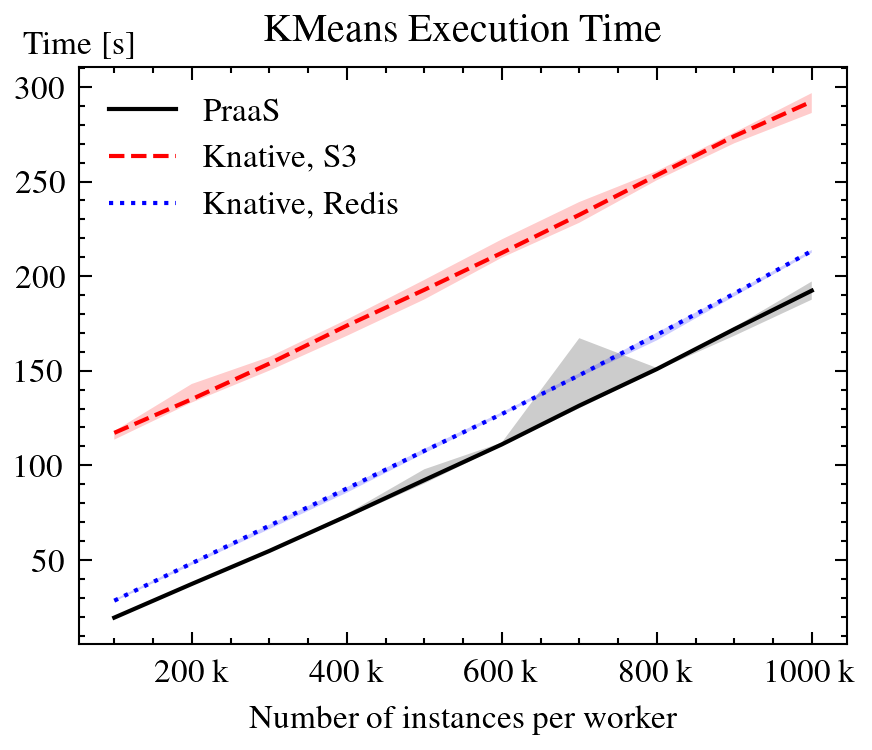

In [26]:
data = group_runs(input_data, "BenchKMeans", "kmeans", filter_first_n=1)
res_data = groups_by_version(data, "intParams", "res")
data = groups_by_version(data, "intParams", "value")
data = unbox_group_val(data, "intParams")
data = reduce_groups(data, "value")
for version in data.keys():
   data[version]["median"] = np.divide(data[version]["median"], 1000)
   data[version]["low"] = np.divide(data[version]["low"], 1000)
   data[version]["high"] = np.divide(data[version]["high"], 1000)
   data[version]["intParams"] = np.divide(data[version]["intParams"], 1000)

print('data')
for version, fields in data.items():
    print(version)
    print(" ", fields["median"])
    #for field, vals in fields.items():
        #print(" ", field, vals)
data = groups_to_error(data, "intParams")

plt.title("KMeans Execution Time")
plot_with_error_fill(data)

plt.xlabel("Number of instances per worker")
plt.ylabel("Time [s]", rotation=0)
axs = plt.gca()
axs.yaxis.set_label_coords(0, 1.01)
axs.xaxis.set_major_formatter(lambda x, pos: f"{int(x)} k")

handles, labels = axs.get_legend_handles_labels()
plt.legend(handles=handles, labels=["PraaS", "Knative, S3", "Knative, Redis"])

axs.figure.savefig("kmeans.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

### Additional plots

In [37]:
def extract_values_from_res(data, *fields):
    new_data = dict()
    for version, groups in data.items():
        new_data[version] = list()
        for group in groups:
            new_group = dict()
            new_data[version].append(new_group)

            # Get non-res fields
            for f in fields:
                if f in group:
                    new_group[f] = group[f]
            res_data = group["res"]
            for res_entry in res_data:
                vals = dict()
                for worker, res_vals in res_entry.items():
                    for f in fields:
                        if f in res_vals:
                            if f in vals:
                                vals[f] += res_vals[f]
                            else:
                                vals[f] = res_vals[f]
                for field, value in vals.items():
                    if field not in new_group:
                        new_group[field] = list()
                    new_group[field].append(value)
    return new_data


def fields_to_version(data, *fields):
    new_data = dict()
    for version, groups in data.items():
        for group in groups:
            duplicated_fields = [f for f in group.keys() if f not in fields]
            for field in fields:
                # field_name = {
                #     "compute_epoch_time": "Total Computation Time",
                #     "sync_epoch_time": "Total Communication Time",
                #     "data_read": "Total Dataset Read Time"
                # }[field]
                field_name = {
                    "compute_epoch_time": "compute",
                    "sync_epoch_time": "sync",
                    "data_read": "read"
                }[field]

                if field_name not in new_data:
                    new_data[field_name] = dict()
                if version not in new_data[field_name]:
                    new_data[field_name][version] = list()

                new_group = {
                    "value": group[field]
                }
                for f in duplicated_fields:
                    new_group[f] = group[f]
                new_data[field_name][version].append(new_group)

    return new_data

def plot_percent_bar(data, x_field, width=70):
    totals = dict()
    for operation, versions in data.items():
        for version, fields in versions.items():
            vals = fields["median"]

            if version not in totals:
                totals[version] = vals
            else:
                totals[version] = np.add(totals[version], vals)

    percentages = dict()
    for operation, versions in data.items():
        for version, fields in versions.items():
            vals = fields["median"]
            if version not in percentages:
                percentages[version] = dict()
            percentages[version][operation] = np.multiply(np.divide(vals, totals[version]), 100)

    labels = list()
    num_versions = len(percentages)
    version_idx = 0
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, axs = plt.subplots(num_versions, sharex="all")
    for version, operations in percentages.items():
        bottom = None
        op_idx = 0
        labels = list(operations.keys())
        for op_name, vals in operations.items():
            print(op_name, vals)
            x_vals = data[op_name][version][x_field]

            if bottom is None:
                bottom = np.zeros(len(x_vals))

            if version_idx == 0:
                pad = -18
            else:
                pad = -20
            axs[version_idx].set_title(version, y=1.0, pad=pad, x=1.015, loc="left")
            # axs[version_idx].set_title(version, pad=0)
            axs[version_idx].bar(x_vals, vals, bottom=bottom, width=width, color=colors[op_idx])
            bottom = np.add(bottom, vals)
            op_idx += 1
        version_idx += 1
    # axs[1].legend(labels, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    fig.legend(labels, loc="upper right", ncol=len(labels), bbox_to_anchor=(0.85, 0.95))
    plt.subplots_adjust(wspace=0, hspace=0)


read [58.72468604 61.14476305 62.61078905 62.45915679 62.32977767 61.85939335
 61.05142822 60.93735526 60.04934411 59.63471013]
sync [14.99437705 11.43762079  8.82482711  8.05259914  7.12632785  6.65893602
  6.74930795  5.49202042  5.54657887  5.28442283]
compute [26.28093691 27.41761616 28.56438384 29.48824407 30.54389448 31.48167063
 32.19926383 33.57062432 34.40407702 35.08086704]
read [10.69664703 18.64558318 24.7099578  29.19144627 32.88585814 35.76082675
 38.03071345 40.02443319 41.49455342 43.3506005 ]
sync [85.70368108 74.91998568 66.44470378 59.80065059 54.20321734 49.3537301
 45.49823704 41.59756499 38.47919678 34.96061884]
compute [ 3.5996719   6.43443115  8.84533842 11.00790314 12.91092452 14.88544315
 16.47104952 18.37800182 20.0262498  21.68878066]
read [44.60648591 52.64796041 55.67392685 57.74717869 59.05613448 59.7950739
 60.21491284 60.45642852 60.16057591 59.61819767]
sync [40.43594333 28.91888411 24.28984983 20.29857246 16.94363394 14.88789543
 13.18872491 11.579202

Text(0.5, 0.98, 'Ratio of data read vs communication vs computation')

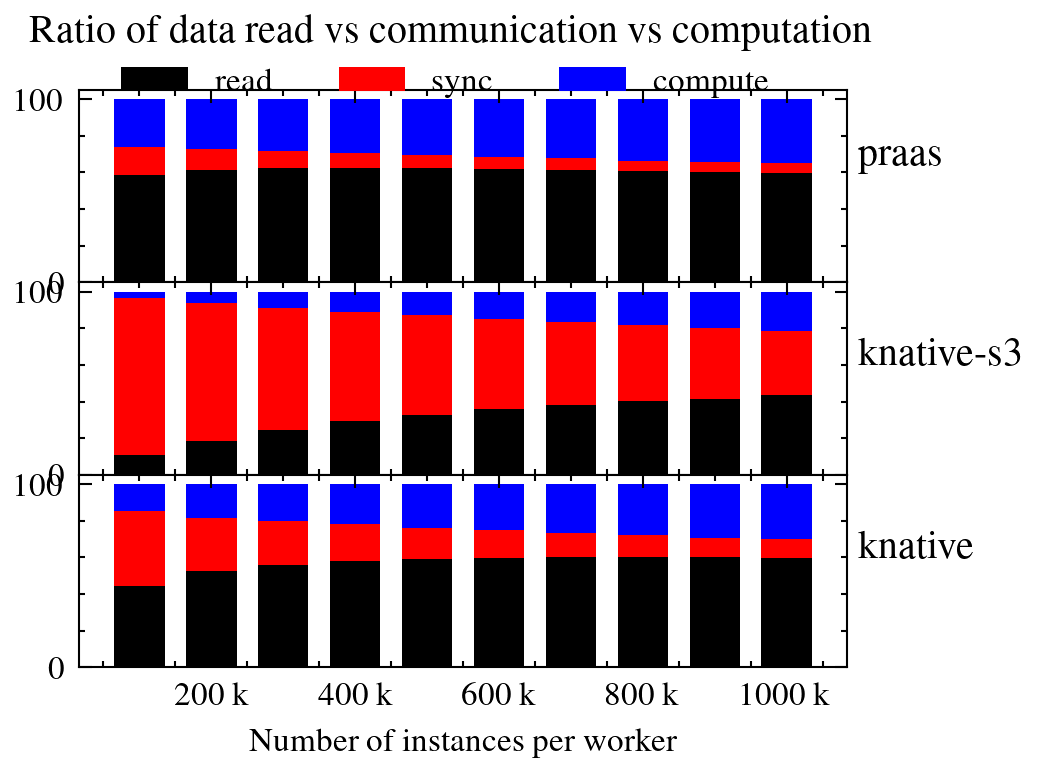

In [40]:
data = group_runs(input_data, "BenchKMeans", "kmeans", filter_first_n=1)
res_data = groups_by_version(data, "intParams", "res")
res_data = unbox_group_val(res_data, "intParams")
res_data = extract_values_from_res(res_data, "data_read", "sync_epoch_time", "compute_epoch_time", "intParams")
res_data = fields_to_version(res_data, "data_read", "sync_epoch_time", "compute_epoch_time")
for operation, versions in res_data.items():
    res_data[operation] = reduce_groups(versions, "value")
for operation, versions in res_data.items():
    #print(operation)
    for version, groups in versions.items():
        #print(" ", version)
        versions[version]["intParams"] = np.divide(versions[version]["intParams"], 1000)
        for field, vals in groups.items():
            pass
            #print("   ", field, vals)

plot_percent_bar(res_data, "intParams")
plt.xlabel("Number of instances per worker")
axs = plt.gca()
axs.xaxis.set_major_formatter(lambda x, pos: f"{int(x)} k")
plt.suptitle("Ratio of data read vs communication vs computation")

#save_current_plot("kmeans-ratio")



In [29]:
def new_figure(idx):
    plt.figure(idx, dpi=dpi)

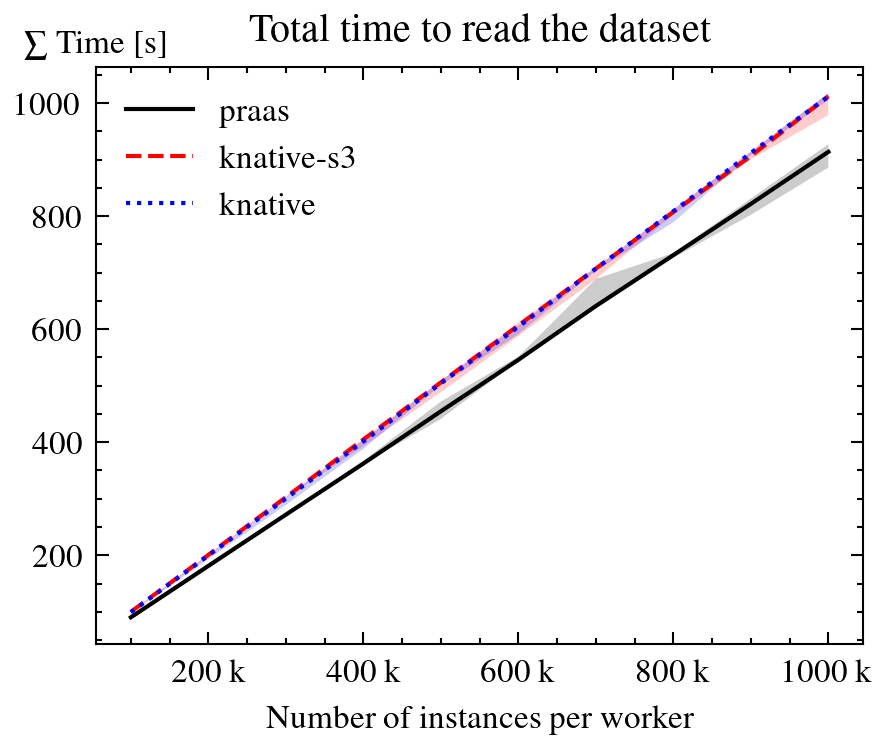

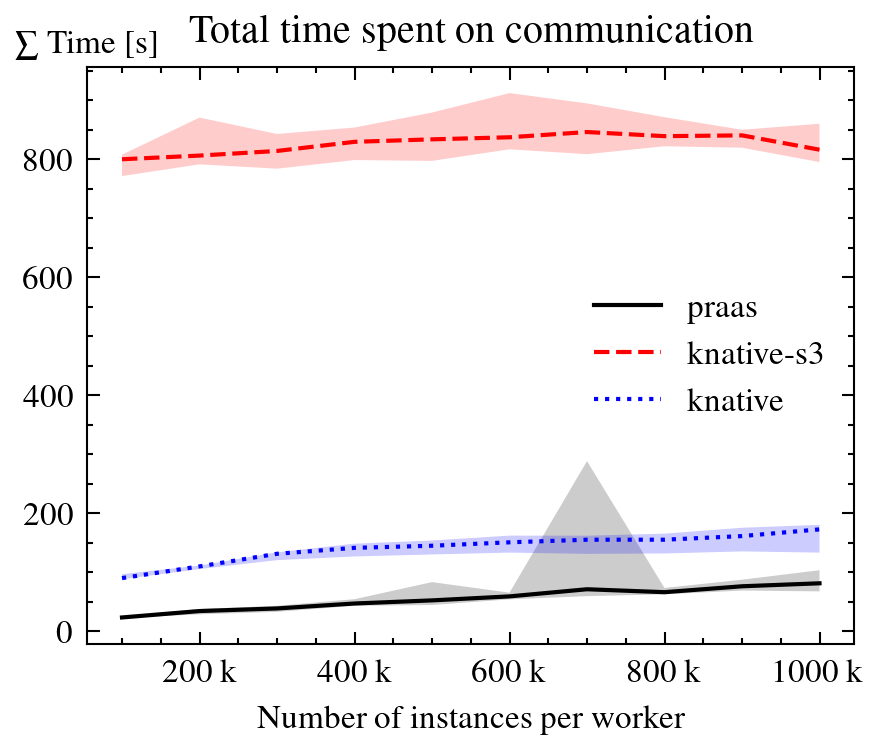

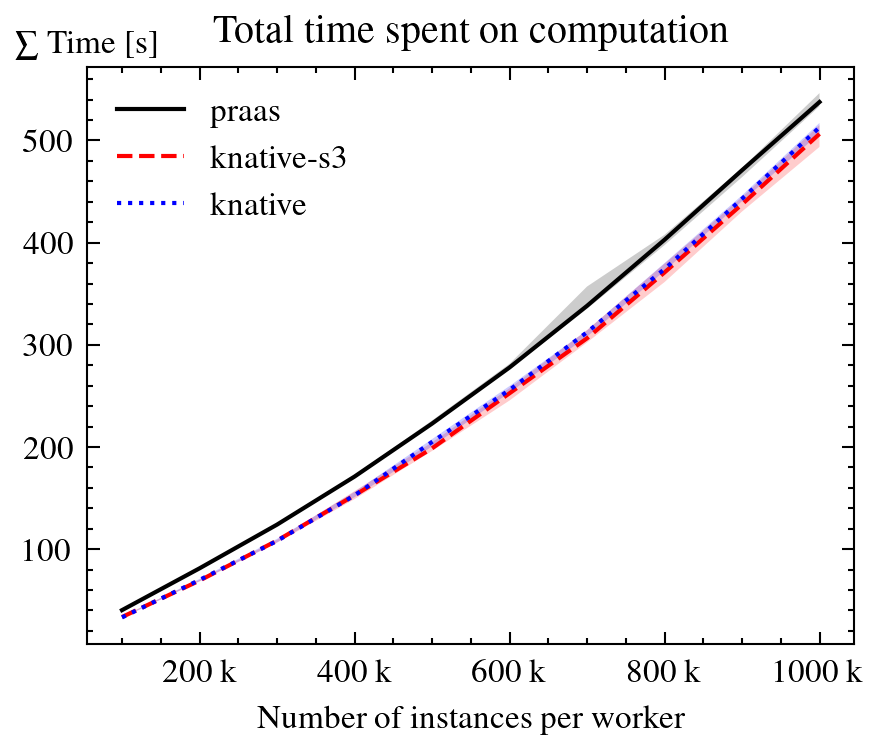

In [42]:

fig_idx = 3
titles = {
    "read": "Total time to read the dataset",
    "sync": "Total time spent on communication",
    "compute": "Total time spent on computation"
}
for operation, versions in res_data.items():
    new_figure(fig_idx)
    fig_idx += 1
    plt.title(titles[operation])
    plot_with_error_fill(groups_to_error(versions, "intParams"))
    plt.xlabel("Number of instances per worker")
    plt.ylabel("$\\sum$ Time [s]", rotation=0)
    axs = plt.gca()
    axs.yaxis.set_label_coords(0, 1.01)
    axs.xaxis.set_major_formatter(lambda x, pos: f"{int(x)} k")

    #save_current_plot(f"kmeans-{operation}")